# Imports

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import ete3
import cassiopeia as cas

# Helper functions for simulation

In [2]:
def simulate_imbalanced_tree(num_init_cells, init_death_prob=0.1, init_repr_prob=0.75,
                             cancer_prob=1e-3, tree_depth=15):
    num_cells = num_init_cells
    death_probs = [init_death_prob] * num_cells
    repr_probs = [init_repr_prob] * num_cells

    init_cells = [str(i) for i in np.arange(num_cells)]
    parent_ix = []
    cell_names = [np.array(init_cells)]
    repetition_coefs_list = []

    for i in range(tree_depth):
        dying = np.random.random(num_cells) < death_probs
        mutating = np.random.random(num_cells) < repr_probs

        repetition_coefs = (mutating+1)*(1-dying)

        repetition_coefs_list.append(repetition_coefs)
        next_gen = np.repeat(init_cells, repetition_coefs)

        if len(next_gen) == 0:
            raise Exception('No cells left to replicate. Terminate simulation.')
        # Label generation in terms of binary split with parents
        binary_labels = [next_gen[i]+'1' if next_gen[i-1] == next_gen[i] else
                         next_gen[i]+'0' for i in range(1, len(next_gen))]
        binary_labels = [next_gen[0]+'0'] + binary_labels
        cell_names.append(np.array(binary_labels))
        parent_ix.append(np.repeat(np.arange(num_cells), repetition_coefs))

        death_probs = np.repeat(death_probs, repetition_coefs)
        repr_probs = np.repeat(repr_probs, repetition_coefs)

        num_cells = sum(repetition_coefs)

        init_cells = binary_labels

        # Introduce cancerous mutations which may increase tumour fitness
        has_cancer = np.random.random(num_cells) < cancer_prob
        death_probs[has_cancer] -= 1e-2
        repr_probs[has_cancer] += 1e-2

    return cell_names

In [3]:
def generate_cassettes(num_cells, cassette_size, mutation_probs=None, deletion_probs=None):
    """
    CRISPR edits are independent of each other. Each edit site has some probability of being modified or being deleted
    The only dependence between cells is that a site which has already been edited or deleted cannot be edited or deleted again

    We can a priori simulate CRISPR edits for a given number of cells and then attach these edits to cells in the lineage
    independently of one another as vector operations for speed up

    @param: num_cells (int) - Number of cells for which we should simulate CRISPR recording cassettes
    @param: cassette_size (int) - Number of sites where CRISPR edits can occur
    """

    print('THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!')

    total_internal_nodes = num_cells  # Is this right? Previously total_internal_nodes was not defined here

    cassette_edits = np.random.randint(low=-1, high=100, size=(total_internal_nodes, cassette_size))

    indices = np.random.choice(np.arange(cassette_edits.size), replace=False,
                               size=int(cassette_edits.size * 0.8))
    cassette_edits[np.unravel_index(indices, cassette_edits.shape)] = 0
    return (cassette_edits.tolist())

In [4]:
def graph_to_ete3(G):
    """
    Convert networkx DiGraph to ete3 tree
    """
    import ete3
    import itertools
    root = "ROOT"
    subtrees = {node:ete3.Tree(name=node) for node in G.nodes()}
    [*map(lambda edge:subtrees[edge[0]].add_child(subtrees[edge[1]]), G.edges())]
    tree = subtrees[root]
    return tree


def copy_attributes(nxgraph, ete3tree):
    for name, node in nxgraph.nodes.items():
        copy = ete3tree & name  # get first node matching the name
        for feature, data in node.items():
            copy.add_feature(feature, data)
    return ete3tree

In [5]:
def generate_lineage(cell_names, cassette_edits):
    """
    Given binary names of cells in a subsample tree and corresponding CRISPR edits for each cell,
    construct a networkx graph representing parental lineages and accumulated CRISPR edits.
    """
    lineage = nx.DiGraph()
    cassette_size = len(cassette_edits[0])
    blank_cassette = [0]*cassette_size
    for generation, cells in enumerate(cell_names):
        for cell in cells:

            lineage.add_node(cell, generation=generation, cassette_state=np.array(blank_cassette), crispr_edit=blank_cassette)
            if len(cell) == 1:
                # Then this cell has no real parent
                lineage.add_edge("ROOT", cell)
                crispr_edit = np.array(cassette_edits.pop())
                lineage.nodes[cell]['crispr_edit'] = crispr_edit
                lineage.nodes[cell]['cassette_state'] = crispr_edit
                continue
            # Add an adge between parent node and recently added child
            parent = cell[:-1]
            lineage.add_edge(parent, cell)

            # Sample a crispr edit for this cell
            crispr_edit = np.array(cassette_edits.pop())
            # Sites which are already edited in lineage are forbidden to be edited again
            parent_state = lineage.nodes()[parent]['cassette_state']
            crispr_edit[parent_state != 0] = 0

            lineage.nodes[cell]['crispr_edit'] = crispr_edit
            lineage.nodes[cell]['cassette_state'] = crispr_edit+parent_state

    return lineage

In [6]:
def simulate_lineage(cassette_size, num_init_cells, init_death_prob=0.1,
                     init_repr_prob=0.75, cancer_prob=1e-3, tree_depth=15):

    # Simulate tree
    cell_names = simulate_imbalanced_tree(num_init_cells=num_init_cells, init_death_prob=init_death_prob,
                                          init_repr_prob=init_repr_prob, cancer_prob=cancer_prob,
                                          tree_depth=tree_depth)

    # Generate cassette edits for each internal node
    total_internal_nodes = sum([len(x) for x in cell_names])
    cassette_edits = generate_cassettes(total_internal_nodes, cassette_size=cassette_size)

    # Generate networkx lineage object
    lineage = generate_lineage(cell_names, cassette_edits)
    return lineage

In [7]:
def drop_missing_data(lineage, missing_fraction):
    """
    Generate a copy of the lineage graph with missing data (represented as '-' in character matrix)
    """
    # assuming networkx tree:
    for node in lineage.nodes.values():
        if 'cassette_state' in node:
            state = list(node['cassette_state'])
            for i in range(len(state)):
                if(np.random.random() < missing_fraction):
                    state[i] = '-'
            node['cassette_state'] = state

# Run lineage tracing simulation

In [124]:
lineage = simulate_lineage(cassette_size=5, num_init_cells=2, init_death_prob=0.1,
                           init_repr_prob=0.75, cancer_prob=1e-3, tree_depth=5)

# for name, cell in lineage.nodes.items():
#    print(name)
#    if 'cassette_state' in cell.keys():
#        print(cell['cassette_state'])

drop_missing_data(lineage, 0.2)
tree = graph_to_ete3(lineage)
tree = copy_attributes(lineage, tree)
print(tree.get_ascii())

THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!

                 /00000-000000
          /0000000
         |      |     /-000010
       /00       \00001
      |  |            \-000011
      |  |
    /0|   \-001
   |  |
   |  |   /-010
   |   \01
-ROOT    |            /-011000
   |      \011011001100
   |                  \-011001
   |
    \-1


# Manipulating lineage graphs

In [9]:
def get_character_matrix(lineage):
    """
    Return pd.DataFrame containing character matrix - maps cell IDs of leaf nodes to CRISPR edits.
    """
    # assuming ete3 tree:
    leaves = lineage.get_leaves()
    names = [str(leaf.name) for leaf in leaves]
    cassette_states = [leaf.cassette_state for leaf in leaves]
    df = pd.DataFrame(data=cassette_states, columns=list(range(0, 5)))
    df.insert(0, 'name', names)
    df = df.set_index('name')
    return df


def annotate_depths(lineage):
    # assuming ete3 tree
    for node in lineage.traverse("preorder"):
        if node.is_root():
            node.add_feature('depth', 0)
        else:
            node.add_feature('depth', node.up.depth+1)


def measure_imbalance(lineage):
    # assuming ete3 tree
    annotate_depths(lineage)
    leaf_depths = []
    for node in lineage.get_leaves():
        leaf_depths.append(node.depth)
    return max(leaf_depths) - min(leaf_depths)


def save(lineage):
    """
    Save a copy of lineage networkx DiGraph is some easily read form
    """

    raise NotImplementedError

In [10]:
matrix = get_character_matrix(tree)
matrix.head()

,0,1,2,3,4
name,,,,,
000,0,48,25,72,0
00100,55,69,-,72,0
001100,-,69,0,-,0
001101,95,-,0,72,-
001110,95,69,0,72,98


# Benchmark against Cassiopeia

Cassiopeia should be able to read in both networkx trees and ete3 trees. See if you can generate some imbalanced trees, quantify how imbalanced they are (some sort of distribution of tree depths or something like that?) and record the performance of NJ vs Cassiopeia vs Scelestical

Also test these as a function of missing data 

In [11]:
def cass_char_matrix(char_matrix):
    char_matrix = char_matrix.replace('-', '-1')
    for column in char_matrix.columns:
        char_matrix[column] = char_matrix[column].astype(int)
    return char_matrix


matrix = cass_char_matrix(matrix)
matrix.head()

,0,1,2,3,4
name,,,,,
000,0,48,25,72,0
00100,55,69,-1,72,0
001100,-1,69,0,-1,0
001101,95,-1,0,72,-1
001110,95,69,0,72,98


In [12]:
# base truth tree:
truth_tree = cas.data.CassiopeiaTree(character_matrix=matrix, tree=lineage)

In [13]:
def compute_priors(char_matrix):
    priors = {}
    for i in range(len(char_matrix.columns)):
        count = char_matrix[i].value_counts()
        if -1 in count:
            del(count[-1])
        freq = count/sum(count)
        priors[i] = freq.to_dict()
    return priors


priors = compute_priors(matrix)
print(priors)

{0: {0: 0.3333333333333333, 95: 0.25, 71: 0.16666666666666666, 55: 0.08333333333333333, 46: 0.08333333333333333, 30: 0.08333333333333333}, 1: {69: 0.2857142857142857, 51: 0.21428571428571427, 32: 0.21428571428571427, 46: 0.14285714285714285, 48: 0.07142857142857142, 36: 0.07142857142857142}, 2: {0: 0.3333333333333333, 53: 0.3333333333333333, 1: 0.25, 25: 0.08333333333333333}, 3: {72: 0.38461538461538464, 23: 0.38461538461538464, 0: 0.23076923076923078}, 4: {57: 0.38461538461538464, 0: 0.3076923076923077, 98: 0.15384615384615385, 27: 0.15384615384615385}}


In [14]:
cas_tree = cas.data.CassiopeiaTree(character_matrix=matrix, priors=priors, missing_state_indicator=-1)

In [15]:
cas_tree.character_matrix.head(5)

,0,1,2,3,4
name,,,,,
000,0,48,25,72,0
00100,55,69,-1,72,0
001100,-1,69,0,-1,0
001101,95,-1,0,72,-1
001110,95,69,0,72,98


In [16]:
cas_tree.n_cell, cas_tree.n_character

(16, 5)

In [17]:
cas_tree.priors[0]

{0: 0.3333333333333333,
 95: 0.25,
 71: 0.16666666666666666,
 55: 0.08333333333333333,
 46: 0.08333333333333333,
 30: 0.08333333333333333}

In [18]:
def add_character_meta(tree):
    character_matrix = tree.character_matrix

    missing_proportion = (character_matrix == -1).sum(axis=0) / character_matrix.shape[0]
    uncut_proportion = (character_matrix == 0).sum(axis=0) / character_matrix.shape[0]
    n_unique_states = character_matrix.apply(lambda x: len(np.unique(x[(x != 0) & (x != -1)])), axis=0)
    character_meta = pd.DataFrame([missing_proportion, uncut_proportion, n_unique_states],
                                  index=['missing_prop', 'uncut_prop', 'n_unique_states']).T
    tree.character_meta = character_meta


add_character_meta(cas_tree)

In [19]:
vanilla_greedy = cas.solver.VanillaGreedySolver()
vanilla_greedy.solve(cas_tree, collapse_mutationless_edges=True)

In [20]:
rf, rf_max = cas.critique.compare.robinson_foulds(truth_tree, cas_tree)
print(rf/rf_max)
triplets = cas.critique.compare.triplets_correct(truth_tree, cas_tree, number_of_trials=500)
# print(triplets)
np.mean(list(triplets[0].values()))

0.391304347826087


0.6148

In [21]:
from collections import defaultdict
from tqdm.auto import tqdm
algorithms = {"Vanilla Greedy": cas.solver.VanillaGreedySolver(),
              'UPGMA': cas.solver.UPGMASolver(dissimilarity_function=cas.solver.dissimilarity.weighted_hamming_distance),
              'NeighborJoining': cas.solver.NeighborJoiningSolver(dissimilarity_function=cas.solver.dissimilarity.weighted_hamming_distance, add_root=True)
              }

iterations = 20

performance_triplets = defaultdict(list)
performance_rf = defaultdict(list)
imbalances = []
cancer_probs = [1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
cancer_probs_results = []
for cancer_prob in cancer_probs:
    algorithm_to_performance_triplets = defaultdict(list)
    algorithm_to_performance_rf = defaultdict(list)
    for _ in tqdm(range(iterations)):
        try:
            lineage = simulate_lineage(cassette_size=5, num_init_cells=2, init_death_prob=0.1,
                                       init_repr_prob=0.75, cancer_prob=cancer_prob, tree_depth=12)
        except Exception:
            print('lineage simulation failed, skipping this tree')
            continue
        drop_missing_data(lineage, 0.2)
        tree = graph_to_ete3(lineage)
        imbalance = measure_imbalance(tree)
        imbalances.append(imbalance)
        cancer_probs_results.append(cancer_prob)
        tree = copy_attributes(lineage, tree)
        matrix = get_character_matrix(tree)
        matrix = cass_char_matrix(matrix)
        priors = compute_priors(matrix)

        ground_truth_tree = cas.data.CassiopeiaTree(character_matrix=matrix, tree=lineage,
                                                    missing_state_indicator=-1)
        add_character_meta(ground_truth_tree)

        np.random.seed(None)

        for algorithm_name in algorithms.keys():

            algorithm = algorithms[algorithm_name]

            reconstructed_tree = cas.data.CassiopeiaTree(character_matrix=matrix,
                                                         priors=priors, missing_state_indicator=-1)
            add_character_meta(reconstructed_tree)
            algorithm.solve(reconstructed_tree)

            # ground_truth_tree.collapse_mutationless_edges(infer_ancestral_characters = False)
            reconstructed_tree.collapse_mutationless_edges(infer_ancestral_characters=True)

            rf, rf_max = cas.critique.compare.robinson_foulds(ground_truth_tree, reconstructed_tree)

            triplets = cas.critique.compare.triplets_correct(ground_truth_tree, reconstructed_tree,
                                                             number_of_trials=500)

            performance_triplets[algorithm_name].append(np.mean(list(triplets[0].values())))
            performance_rf[algorithm_name].append(rf / rf_max)
#             algorithm_to_performance_triplets[algorithm_name].append(np.mean(list(triplets[0].values())))

#             algorithm_to_performance_rf[algorithm_name].append(rf / rf_max)
#     for algo in algorithms.keys():
#         performance_triplets[algo].append(np.mean(algorithm_to_performance_triplets[algo]))
#         performance_rf[algo].append(np.mean(algorithm_to_performance_rf[algo]))

  0%|          | 0/20 [00:00<?, ?it/s]

THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE T

  0%|          | 0/20 [00:00<?, ?it/s]

THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
lineage simulation failed, skipping this tree
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEH

  0%|          | 0/20 [00:00<?, ?it/s]

THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE T

  0%|          | 0/20 [00:00<?, ?it/s]

THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE T

  0%|          | 0/20 [00:00<?, ?it/s]

THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE THIS!
THIS IS A PLACEHOLDER FOR THE REAL CASSETTE FUNCTION. CHANGE T

In [22]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

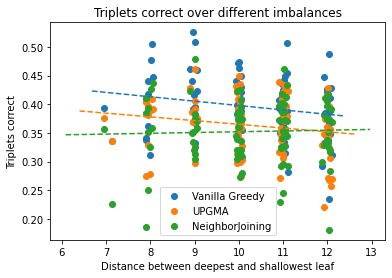

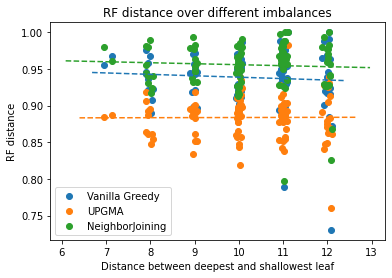

In [23]:
metric_dict = {'Triplets correct':performance_triplets, 'RF distance':performance_rf}
imbalances_jitter = imbalances + np.random.normal(scale=0.05, size=len(imbalances))
for metric, performance in metric_dict.items():
    for algo in algorithms.keys():
        plt.scatter(imbalances_jitter, performance[algo], label=algo)
        x = np.array(imbalances).reshape(-1, 1)
        y = np.array(performance[algo])
        model = LinearRegression().fit(x, y)
        line_x = np.array(plt.xlim())
        line_y = model.intercept_ + model.coef_[0] * line_x
        plt.plot(line_x, line_y, '--')

    plt.title(metric + " over different imbalances")
    plt.xlabel('Distance between deepest and shallowest leaf')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

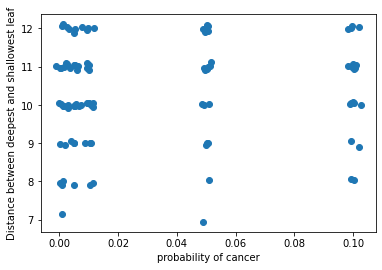

In [29]:
cancer_probs_jitter = cancer_probs_results + np.random.normal(scale=0.001, size=len(cancer_probs_results))
plt.scatter(cancer_probs_jitter, imbalances_jitter)
plt.xlabel("probability of cancer")
plt.ylabel("Distance between deepest and shallowest leaf")
plt.show()

In [129]:
def get_dendrotree(etetree):
    from dendropy import Tree as DTree
    return DTree.get(data=etetree.write(format=1), schema='newick')


import dendropy

# return dendropy character matrix
# NOT WORKING YET (need to figure out dendropy alphabet)
def get_dendro_cm(etetree):
    leaves = etetree.get_leaves()
    names = [str(leaf.name) for leaf in leaves]
    states = [leaf.cassette_state for leaf in leaves]
    new_states = []
    for state in states:
        new_state=[]
        for i in range(len(state)):
            if state[i] == "-":
                newchar = chr(0)
            else:
                newchar = chr(state[i]+1)
            new_state.append(newchar)
        new_states.append(new_state)
    # print(new_states)
    cassette_states = [''.join(state) for state in new_states]
    # print(cassette_states)
    char_dict = dict(zip(names, cassette_states))
    alphabet = dendropy.datamodel.charstatemodel.StateAlphabet(''.join(map(chr,range(0,101))))
    return dendropy.StandardCharacterMatrix.from_dict(char_dict,default_state_alphabet=alphabet)


import sys
sys.path.append('../lateral')  # should have lateral installed in parent directory of this file's directory
import tree_utils as l_tree_utils


def weighbor(est_dists, taxon_namespace, sequence_length):
    est_pdm = l_tree_utils.array_to_pdm(est_dists, taxon_namespace)
    return l_tree_utils.weighbor(est_pdm, sequence_length), None


# turn character matrix into distance estimates under jc69 model.
# not working yet due to missing data

OVERFLOW_DISTANCE = 10
def counts_to_estimates(counts, num_sites):
    num_same = np.trace(counts)
    diffs_per_site = (num_sites - num_same) / num_sites
    if diffs_per_site >= 3/4:  # when most states are different we can just make the distance large
        dist = OVERFLOW_DISTANCE
    else:
        try:
            dist = (-3 / 4) * np.log(1 - (4 / 3) * diffs_per_site)
        except FloatingPointError:
            # no maximum likelihood estimate
            dist = OVERFLOW_DISTANCE
    
    
    variance = np.exp(8 * dist / 3) * diffs_per_site * (1 - diffs_per_site) / num_sites
    return dist, variance


def cm_to_estimates(cm):
    labels = [taxon.label for taxon in cm.taxon_namespace]
    sequences = [cm[label] for label in labels]
    n_species = len(sequences)
    n_sites = len(sequences[0])

    est_dists = np.zeros((n_species, n_species), dtype=np.float64)
    variances = np.zeros((n_species, n_species), dtype=np.float64)
    
    from ctmc import JC69
    for i in range(n_species):
        for j in range(n_species):
            counts = np.zeros((100, 100), dtype=np.float64)
            
            # count transitions for non-missing values
            for site in range(n_sites):
                from_idx = ord(sequences[i][site].symbol) - 1
                to_idx = ord(sequences[j][site].symbol) - 1
                if from_idx != -1 and to_idx != -1:  # if neither value missing missing
                    counts[from_idx, to_idx] += 1
                
            
            # take into account missing values
            for site in range(n_sites):
                from_idx = ord(sequences[i][site].symbol) - 1
                to_idx = ord(sequences[j][site].symbol) - 1
                from_missing = from_idx == -1
                to_missing = to_idx == -1
                if from_missing and not to_missing:
                    to_vec = counts[:, to_idx]
                    if sum(to_vec != 0):
                        props = to_vec/sum(to_vec)
                        # print(to_vec)
                        to_vec += props
                        # print(counts[:, to_idx])
                elif to_missing and not from_missing:
                    from_vec = counts[from_idx, :]
                    if sum(from_vec != 0):
                        
                        props = from_vec/sum(from_vec)
                        # print(from_vec)
                        from_vec += props
                        # print(counts[from_idx,:])
            # print(counts.sum())
            
            dist, variance = counts_to_estimates(counts, n_sites)
            est_dists[i, j] = dist
            variances[i, j] = variance
    return est_dists, variances


def mds(rho, initial_pts, est_dists, variances, hyperboloid, taxon_namespace, sequence_length):
    from cythonised.hyperbolic_mds import MDS
    mds = MDS(rho=rho, lr=0.005, max_step_size=0.1)
    mds.set_points(initial_pts.copy())
    converged, failed, checkpoints = \
        mds.fit(est_dists,
                variances,
                stopping_distance=1e-6,
                max_rounds=100,
                checkpoint_interval=1000)
#         meta = {'converged': converged, 'failed': failed, 'rounds_done': mds.rounds_done}
#         meta['constrained'] = _satisfies_constraints(mds.get_points())
    pw_dists = hyperboloid.pairwise_distances(mds.get_points())
    est_pdm = l_tree_utils.array_to_pdm(pw_dists, taxon_namespace)
    return l_tree_utils.weighbor(est_pdm, sequence_length), None  # meta

# infer using lateral. takes ete3 tree. not working yet due to cm_to_estimates not working
def infer_lateral(tree, min_length=0.05, max_length=0.2, dimension=30, rho=0.5):
    generating_tree = get_dendrotree(tree)
    for e in generating_tree.edges():
        if e.length is not None:
            e.length = np.random.rand() * (max_length - min_length) + min_length
    cm = get_dendro_cm(tree)

    from hyperboloid import Hyperboloid
    hyperboloid = Hyperboloid(local_dimension=dimension, rho=0.5)
    # from paup import get_best_log_likelihood_for_topology, infer_tree as paup_infer_tree
    # generating_tree_ll, _ = get_best_log_likelihood_for_topology(generating_tree, cm)

    est_dists, variances = cm_to_estimates(cm)
    
    #taxon_namespace = [taxon.label for taxon in cm.taxon_namespace]
    est_pdm = l_tree_utils.array_to_pdm(est_dists, cm.taxon_namespace)
    
    sequence_length = len(tree.get_leaves()[0].cassette_state)
    init_tree = l_tree_utils.weighbor(est_pdm, sequence_length)
    # init_tree = weighbor(est_dists, cm.taxon_namespace, sequence_length)
    init_tree.reroot_at_midpoint(update_bipartitions=True, suppress_unifurcations=True)
#     import paup
#     _, init_tree = paup.get_best_log_likelihood_for_topology(init_tree, cm)
    
#     import phyml
#     optimum_tree, _, _ = phyml.infer_tree(cm)
    
    tree, meta = weighbor(est_dists, cm.taxon_namespace, sequence_length)
    
    print(l_tree_utils.robinson_foulds(tree, init_tree))
    
    # rates = l_tree_utils.counts_to_rates(counts)
    
    ZERO_EDGE_LENGTH = 0.0001
    for e in init_tree.edges():
        if e.length is not None:
            if e.length < ZERO_EDGE_LENGTH:
                e.length = ZERO_EDGE_LENGTH

    
    vectors = hyperboloid.embed_tree(init_tree)
    initial_pts = np.array([vectors[init_tree.find_node_for_taxon(taxon)] for taxon in cm.taxon_namespace])
    
    #prevent divide-by-zero errors
    est_dists += 0.001
    variances += 0.001
    
    hyperbolic_tree, _ = mds(rho, initial_pts, est_dists, variances, hyperboloid, cm.taxon_namespace, sequence_length)
    
    print(l_tree_utils.robinson_foulds(tree, hyperbolic_tree)) # why 0?
    from dendropy.calculate import treemeasure
    print(treemeasure.B1(tree))
    print(treemeasure.B1(hyperbolic_tree))
    # why are the results the same??? did they infer the same tree??
    
infer_lateral(tree)



0
0
3.8333333333333335
3.8333333333333335
